## Executive Summary

### Overview

Lung adenocarcinoma is the most common subtype of non-small cell lung cancer, accounting for about 40% of all lung cancers and over 80% of non-small cell lung cancer cases. This report presents a differential methylation analysis of lung adenocarcinoma (Primary Tumor) and normal lung tissue (Solid Tissue Normal) samples obtained from The Cancer Genome Atlas (TCGA). The primary objective was to identify differentially methylated CpG sites that could serve as biomarkers for distinguishing between cancerous and normal tissues, and to explore their biological relevance.

### Key Findings

#### Differential Methylation Analysis
- Performed differential methylation analysis on one-third of the samples to identify CpG sites exhibiting differential methylation between lung adenocarcinoma and normal lung tissue.
- Identified 428 CpG sites that were significantly differentially methylated in cancer versus normal tissue samples.

#### Feature Selection:
- Applied a random forest algorithm to identify differentially methylated sites that are most informative for discriminating between lung adenocarcinoma and normal lung tissue.
- The selected CpG sites were prioritized for further analysis due to their predictive power and potential biological relevance.
- Comparative violin plots highlighted the stark differences in methylation of the selected CpG sites between lung adenocarcinoma and normal lung tissue samples, suggesting distinct methylation patterns with minimal deviation.

#### Model Training and Testing:
- Partitioned the remaining samples into training and testing sets to build and evaluate a random forest model for distinguishing between lung adenocarcinoma and normal lung tissue samples.
- The model achieved perfect classification of the test set, demonstrating high sensitivity and specificity in sample discrimination.
- Performance metrics:
    - Accuracy: 1.0 (100%)
    - Sensitivity: 1.0
    - Specificity: 1.0
- The model's performance highlights the selected CpG sites' potential utility for accurate lung adenocarcinoma tissue identification.

#### Annotation of Selected CpG Sites:
- Retrieved annotation information for the selected CpG sites and biological process ontologies for the genes associated with them.
- The associated genes are predominantly linked with ontologies encompassing growth, development, differentiation, proliferation, transcriptional regulation, transcription factor activity, cell adhesion, homeostasis, motility, apoptosis, and inflammation.

### Conclusion
The distinct methylation patterns observed between cancer and normal lung tissue samples underscore the epigenetic changes associated with lung adenocarcinoma. The involvement of genes proximal to the selected differentially methylated CpG sites in critical biological processes such as growth, proliferation, infalmmation, and apoptosis highlights their potential significance in cancer development and progression.

### Future Directions
- Further validation of the selected CpG sites in independent cohorts to confirm their utility as biomarkers for lung adenocarcinoma.
- Investigation of the functional roles of the selected CpG sites and their proximal genes in cancer biology.
- Exploration of the potential for integrating these biomarkers into liquid biopsy workflows for early detection, prognosis, and therapeutic targeting of lung adenocarcinoma.

## Load Required Libraries

In [1]:
install_and_load <- function(packages) {
    if (!requireNamespace("BiocManager")) {
        install.packages("BiocManager")
    }
    for (package in bioconda_packages) {
        if (!require(package, character.only = TRUE)) {
            BiocManager::install(package, force = TRUE)
            require(package, character.only = TRUE)
        }
    }
    for (package in cran_packages) {
        if (!require(package, character.only = TRUE)) {
            install.packages(package, force = TRUE)
            require(package, character.only = TRUE)
        }
    }
    for (package in dev_packages) {
        package_strip <- str_replace_all(package, ".+\\/", "")
        if (!require(package_strip, character.only = TRUE)) {
            if (!require("devtools", character.only = TRUE)) {
                install.packages("devtools")
            } 
            install_github(package, force = TRUE)
            require(package_strip, character.only = TRUE)
        }
    }
}

cran_packages <- c("dplyr", "tidyverse", "stringr", "ggplot2", "caret", "randomForest")

bioconda_packages <- c("DESeq2", "IlluminaHumanMethylation450kanno.ilmn12.hg19", "biomaRt")

dev_packages <- c("etam4260/kneedle")

suppressWarnings(suppressMessages(install_and_load(packages)))

## Load Datasets
- The dataset used in this study consists of array-based DNA methylation data for primary lung adenocarcinoma and normal lung tissue samples sourced from The Cancer Genome Atlas (TCGA).
- The sample set includes a total of 206 samples from 193 unique donors, ensuring a balanced representation of various demographic and clinical factors.

### Sample Metadata

In [2]:
metadata <- read.delim("gdc_sample_sheet.2024-07-02.tsv", sep = "\t") %>%
    arrange(Sample.ID) %>%
    column_to_rownames("File.ID") %>%
    select(-c(Data.Category, Data.Type, Project.ID)) %>%
    mutate_all(as.factor)

metadata %>%
    mutate_all(as.character) %>%
    select(Sample.Type, Primary.Diagnosis, Gender, Vital.Status, Race, Ethnicity) %>%
    gather(-Sample.Type, key = "Factor", value = "Group") %>%
    group_by(Factor, Group, Sample.Type) %>%
    summarise(Count = n(), .groups = "keep")

Factor,Group,Sample.Type,Count
<chr>,<chr>,<chr>,<int>
Ethnicity,hispanic or latino,Primary Tumor,6
Ethnicity,not hispanic or latino,Primary Tumor,144
Ethnicity,not hispanic or latino,Solid Tissue Normal,31
Ethnicity,not reported,Primary Tumor,25
Gender,female,Primary Tumor,105
Gender,female,Solid Tissue Normal,19
Gender,male,Primary Tumor,70
Gender,male,Solid Tissue Normal,12
Primary.Diagnosis,"Adenocarcinoma, NOS",Primary Tumor,175


### Methylation Intensity Values
- Compiled SeSAMe-generated beta values for all samples into a unified methylation intensity table.
- Converted methylation intensities into integers to facilitate differential methylation analysis.
- Ensured that the column names of the `methylation_count` matrix accurately corresponded to the row names of `metadata`.

In [3]:
read_betas <- function(metadata) {
    for(id in rownames(metadata)) {
        beta_data <- read.delim(paste0("files/", metadata[id, "File.Name"]), header = FALSE,
                                col.names = c("CpG", id), check.names = FALSE)
        if(!exists("beta_table")) {
            beta_table <- beta_data
        } else {
        beta_table <- left_join(beta_table, beta_data, "CpG")
        }
    }
    colnames(beta_table) <- gsub("\\.", "-", colnames(beta_table))
    
    beta_table %>%
        column_to_rownames("CpG") %>% mutate(across(everything(), ~ replace_na(., 0)))
}

methylation_data <- read_betas(metadata)

methylation_count <- methylation_data %>%
    mutate(across(everything(), ~ as.integer(round(. * 100))))

if (all(colnames(methylation_count) == rownames(metadata))) {
  print("Column names of methylation integer matrix match row names of metadata.")
} else {
  print("Column names of methylation integer matrix do not match row names of metadata.")
}

methylation_count

[1] "Column names of methylation integer matrix match row names of metadata."


,13acab0a-17d1-4c38-8580-ee745e49cd4f,e1785dea-699e-4343-9cc7-a45a93494b1e,afc2b386-3661-45e0-81db-88d40b8597d9,db172586-332b-4a89-bd7f-0041104616fb,36338dbd-f4c3-400e-994e-a53ea8060a18,4511db8b-92e3-4e37-868b-52aa0708c29c,dce4d200-db10-40d7-82eb-1685361fdcd8,d04defe2-e4d6-4eac-8a0e-8667d760040f,afe1232d-7f2c-492c-bba5-c2a94e5cfdc5,f4f0c8fc-2b8f-43f1-a747-358d2a717dfa,⋯,5c6fc3b8-94f8-4a2b-af54-79c56c2ce38a,c04f940f-fe0b-4d0b-a94a-1083c63ea952,ebc0d57c-e9f8-44e6-922e-6b39bbbcb0fe,1a91e3e4-a06e-4d00-9498-797c604222f9,dc9196d9-0669-4965-ae19-be1d4d94bf96,a434db66-c204-412c-97a5-b5cbb8ab3963,777ed88d-a1ca-489a-9927-32602c77b539,2c830ceb-c805-4410-b40d-115f5149f417,9e711594-b012-4d84-aa47-5f893690c793,ae7275dd-d6c4-4786-b710-35b270d4050f
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
cg00000292,61,88,85,65,84,52,49,43,59,79,⋯,64,61,79,52,74,54,82,79,81,49
cg00002426,16,89,51,49,35,43,50,92,57,49,⋯,40,39,63,51,60,56,63,46,67,63
cg00003994,34,6,7,6,4,3,5,24,2,14,⋯,49,39,17,11,4,7,48,7,14,10
cg00005847,59,46,46,78,43,35,37,71,14,47,⋯,73,66,33,37,32,58,47,44,35,52
cg00006414,3,4,3,4,3,4,4,4,5,5,⋯,5,6,4,6,6,5,5,7,5,5
cg00007981,2,4,2,3,4,7,8,6,5,3,⋯,5,3,3,3,3,4,4,3,3,3
cg00008493,98,99,99,96,99,99,99,99,99,98,⋯,73,94,84,95,95,94,94,96,95,92
cg00008713,2,2,1,5,2,2,1,2,2,2,⋯,7,7,5,7,7,8,4,6,7,7
cg00009407,1,1,1,4,1,1,1,1,1,1,⋯,5,3,5,3,4,4,3,5,4,4


## Differential Methylation Analysis
- Performed differential methylation analysis on a randomly selected one-third of the samples.
- Contrasted `Primary_Tumor` samples with `Solid_Tissue_Normal` samples to identify differentially methylated CpG sites.
- Excluded CpG sites with very low counts, specifically those with fewer than 10 counts in all samples of one `Sample.Type` group, to avoid noise from low-coverage probes.
- Identified 478 CpG sites (3.9%) that were hypermethylated and 53 CpG sites (0.44%) that were hypomethylated at a 1.5 fold change and adjusted *p* value < 0.1 cutoff.

In [4]:
set.seed(1500)

dge_samples <- createDataPartition(y = metadata$Sample.Type, p = 0.3, list = FALSE)

groups <- metadata[dge_samples, ] %>%
    mutate(Sample.Type=factor(gsub(" ", "_", Sample.Type),
                              levels = c("Solid_Tissue_Normal", "Primary_Tumor")))

dds <- DESeqDataSetFromMatrix(countData = methylation_count[, dge_samples],
                              colData = groups,
                              design = ~ Sample.Type)

dds <- DESeq(dds, fitType = "local", quiet = TRUE)

keep <- rowSums(counts(dds) >= 10) >= min(table(metadata$Sample.Type))

dds <- dds[keep, ]

res <- results(dds, name = "Sample.Type_Primary_Tumor_vs_Solid_Tissue_Normal", lfcThreshold = log2(1.5))

summary(res)


out of 12117 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.58 (up)    : 478, 3.9%
LFC < -0.58 (down) : 53, 0.44%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Selected Significantly Hypermethylated and Hypomethylated CpG Sites
- Criteria for significance:
    - Sites with greater than 1.5-fold hypermethylation or hypomethylation.
    - Adjusted *p* value < 0.05.
- Identified 428 CpG sites that were significantly differentially methylated between `Primary_Tumor` and `Solid_Tissue_Normal` samples.

In [5]:
sig_table <- res %>%
    as.data.frame() %>%
    arrange(-abs(log2FoldChange)) %>%
    filter(!is.na(padj)) %>%
    mutate(sig=ifelse(log2FoldChange < -log2(1.5) & padj < 0.05, "Hypomethylated",
                      ifelse(log2FoldChange > log2(1.5) & padj < 0.05, "Hypermethylated", "Not Significant")))

sig_loci <- unique(row.names(sig_table %>% filter(sig != "Not Significant")))

print(paste(length(sig_loci), "CpG sites are significantly differentially methylated."))

[1] "428 CpG sites are significantly differentially methylated."


### Volcano Plot
- The volcano plot highlights the fold changes and significance levels of CpG site methylation.
- <span style="color: #e3221cff;">Red</span> dots indicate hypermethylation, <span style="color: #377eb8ff;">blue</span> dots indicate hypomethylations, and <span style="color: #06060690;">gray</span> dots represent CpG sites that were not differentially methylated.
- The majority of differentially methylated CpG sites were hypermethylated in `Primary_Tumor` compared to `Solid_Tissue_Normal`.

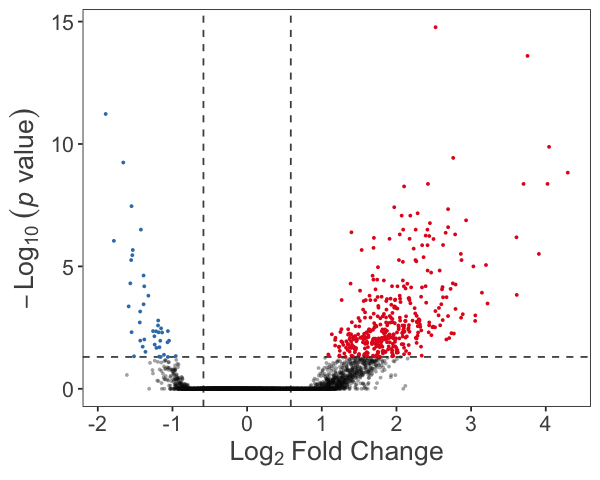

In [14]:
options(repr.plot.width = 5, repr.plot.height = 4)

ggplot(sig_table, aes(x = log2FoldChange, y = -log10(padj), color = sig)) +
    geom_hline(yintercept = -log10(0.05), color = "grey30", linetype = 2) +
    geom_vline(xintercept = c(-1, 1) * log2(1.5), color = "grey30", linetype = 2) +
    geom_point(shape = 16, size = 0.75) +
    scale_color_manual(values = c("#e3221cff", "#377eb8ff", "#06060660")) +
    scale_y_continuous(breaks = seq(0, 30, 5)) +
    scale_x_continuous(breaks = seq(-4, 4, 1)) +
    labs(x = expression(Log[2] ~ "Fold Change"),
         y = expression(-Log[10] ~ (paste(italic(p), " value")))) +
    theme_bw() +
    theme(legend.position = "none",
          panel.grid = element_blank(),
          text = element_text(size = 16, color = "grey30"))

## Feature Selection
- Applied a random forest algorithm to identify differentially methylated sites that most effectively discriminate `Primary_Tumor` from `Solid_Tissue_Normal` samples.
- A subset of 25 CpG sites were identified as highly informative for sample discrimination and were prioritized for further analysis.

In [7]:
set.seed(1500)

filtered_data <- methylation_data[sig_loci, dge_samples]

scaled_data <- t(scale(t(filtered_data)))

combined_data <- t(scaled_data) %>%
    as.data.frame() %>%
    rownames_to_column("Sample") %>%
    left_join(metadata %>% rownames_to_column("Sample"), "Sample")

response_variables <- combined_data %>%
    select(Sample.Type) %>%
    mutate(across(everything(), as.factor))

predictors <- combined_data %>%
    select(-where(is.character), -where(is.factor))

rf_models <- lapply(names(response_variables), function(response_variable) {
    randomForest(response_variables[[response_variable]] ~ ., data = predictors, importance = TRUE)
})

important_loci_list <- lapply(rf_models, function(model) {
    importance <- as.data.frame(importance(model))
    importance <- importance[order(importance$MeanDecreaseGini, decreasing = TRUE), ]
    rownames(importance)[1:kneedle(1:nrow(importance), importance$MeanDecreaseGini)[1]]
})

important_loci <- unlist(important_loci_list)

print(paste("Identified", length(important_loci), "CpG sites as optimal for discriminating tissue types."))

filtered_loci_matrix <- filtered_data[important_loci, ]

[1] "Identified 25 CpG sites as optimal for discriminating tissue types."


### Methylation Intensities of Selected CpG Sites
- Comparative violin plots were used to highlight the differences in methylation of the selected CpG sites across `Sample.Type` and individual samples.
- Distinct methylation patterns were observed, with minimal overlaps between `Primary Tumor` and `Solid Tissue Normal` samples.

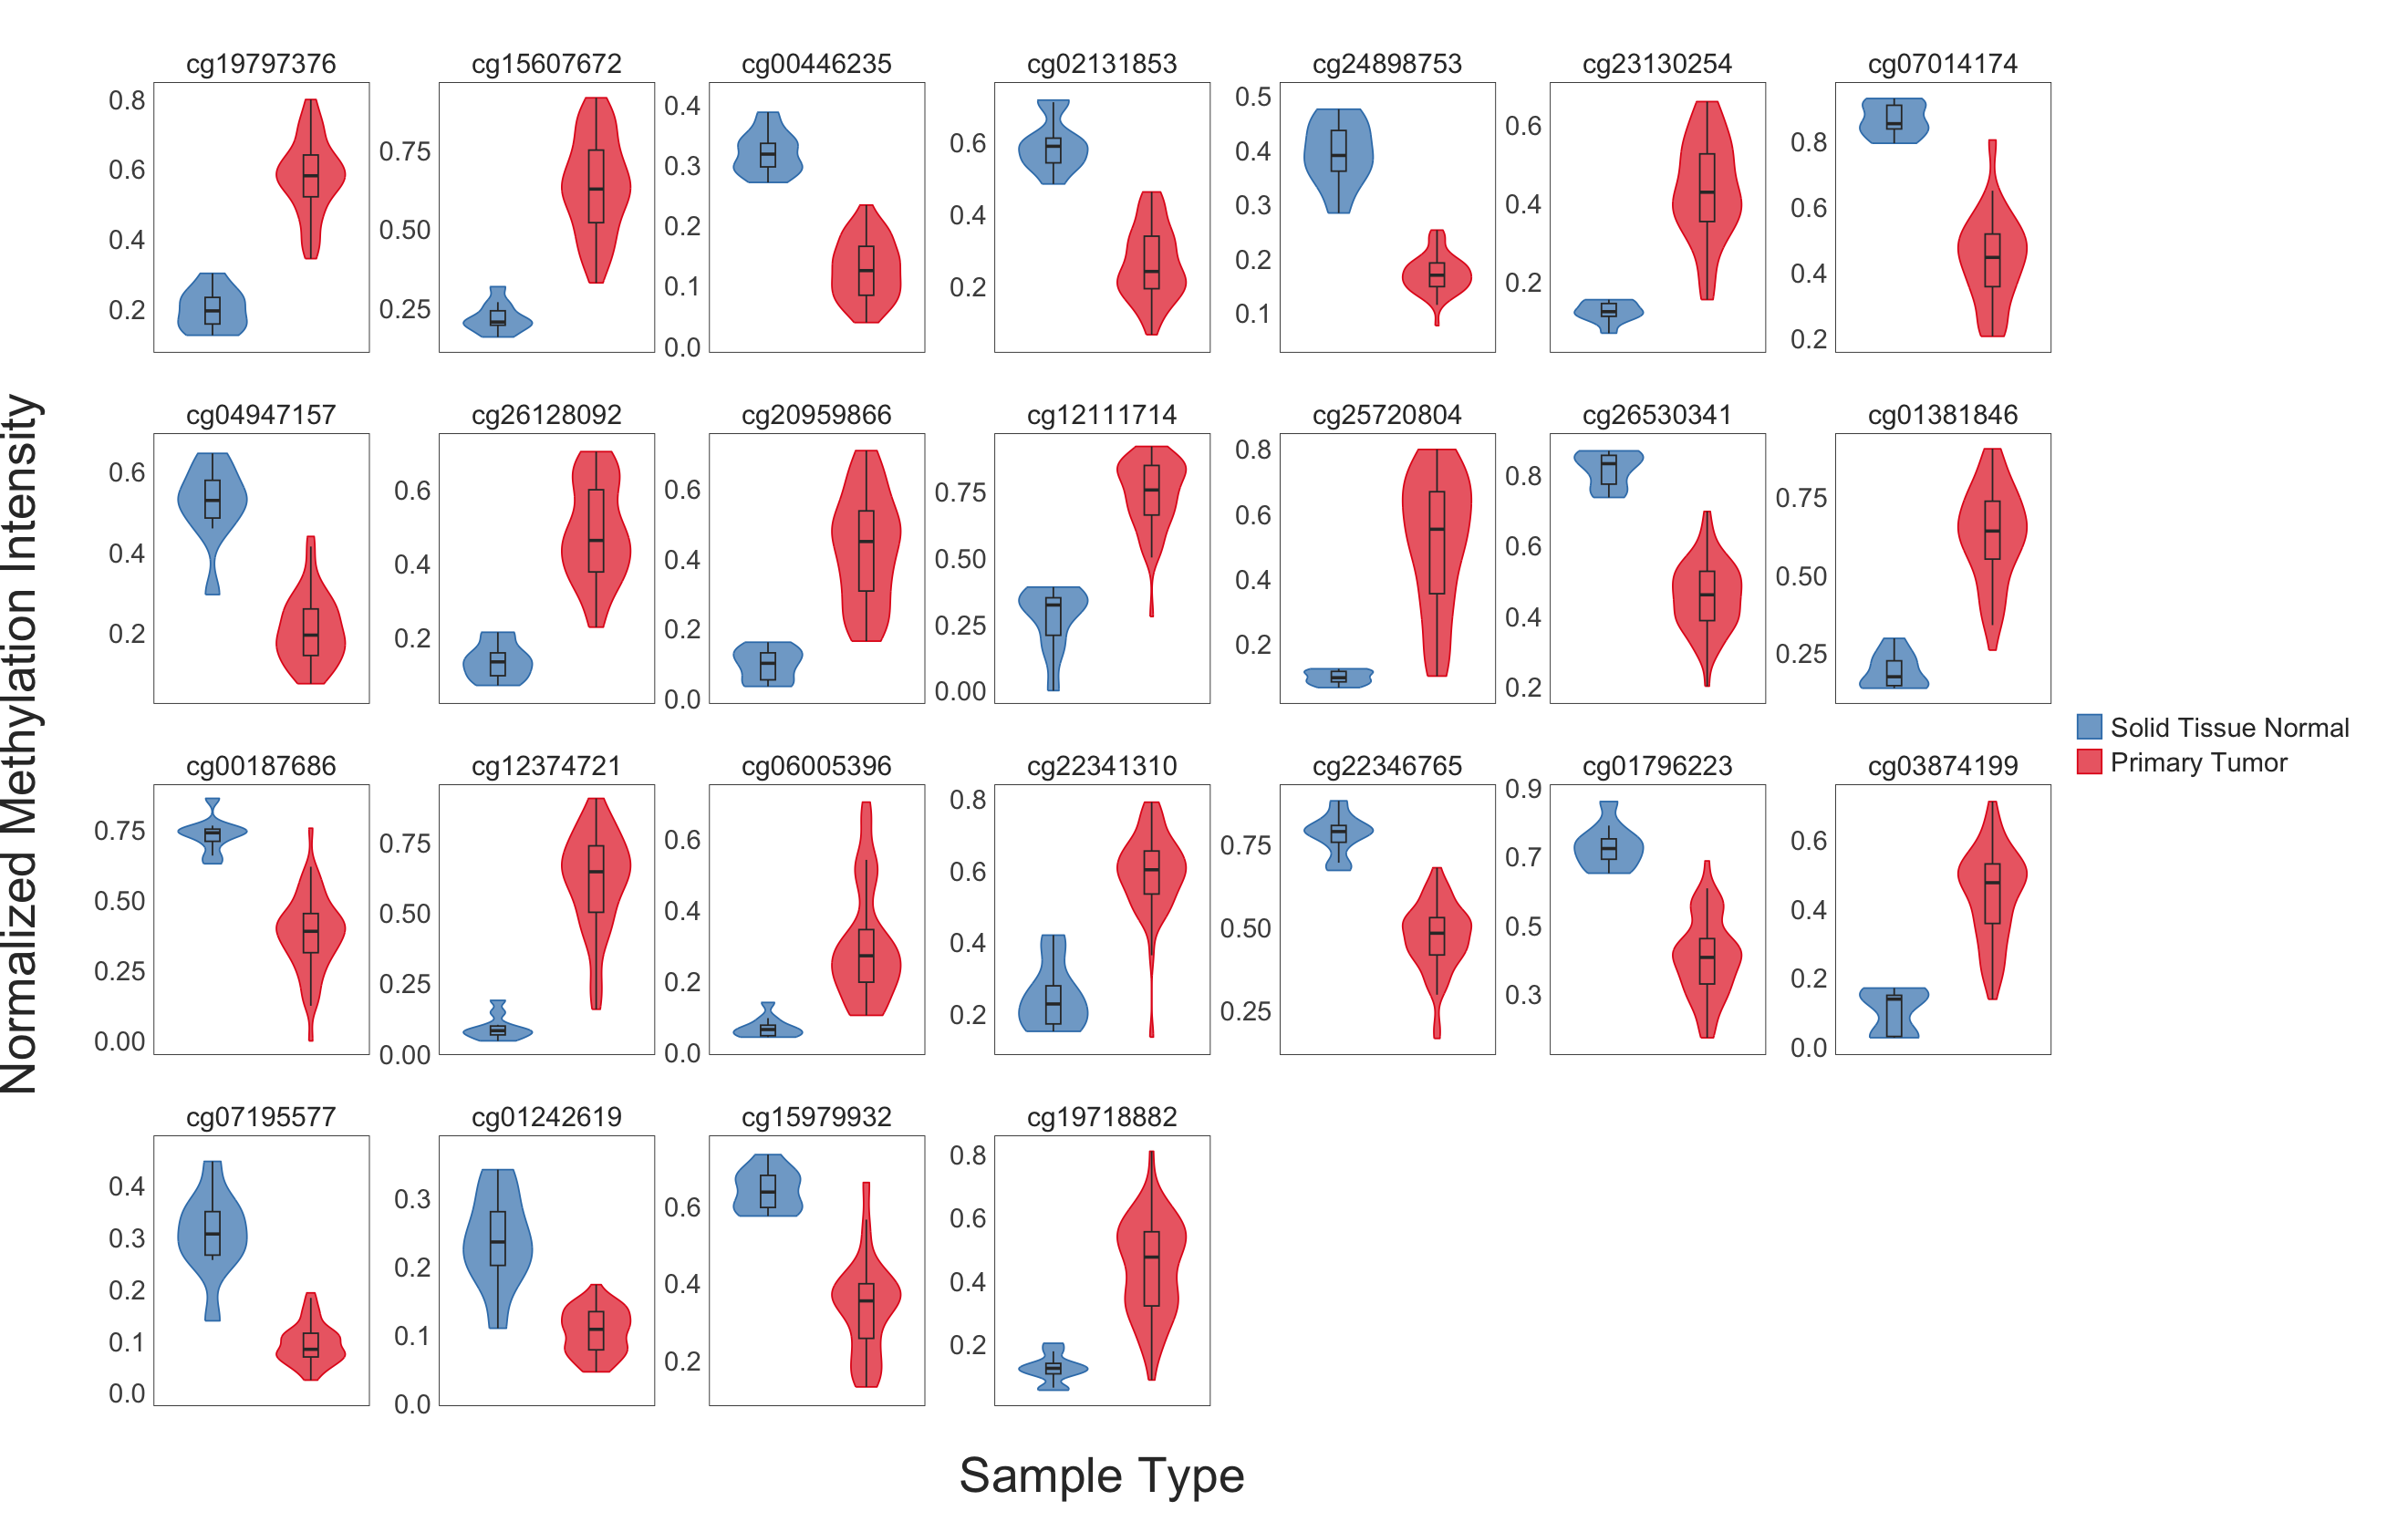

In [ ]:
options(repr.plot.width = 22, repr.plot.height = 14)

filtered_loci_matrix %>%
    as.data.frame() %>%
    rownames_to_column("Symbol") %>%
    gather(1:length(dge_samples) + 1, key = "Case", value = "Normalized Methylation Intensity") %>%
    mutate(`Sample Type` = factor(metadata[Case, "Sample.Type"],
                                  levels = c("Solid Tissue Normal", "Primary Tumor")),
           Symbol = factor(Symbol, levels = important_loci)) %>%
    ggplot(aes(y = `Normalized Methylation Intensity`, x = `Sample Type`,
               fill = `Sample Type`, col = `Sample Type`)) +
        scale_y_continuous(expand = c(0, 0.05)) +
        geom_violin(scale = "width", width = 0.7) +
        geom_boxplot(aes(group = `Sample Type`), fill = NA, color = "grey20", width = 0.15,
                     outlier.shape = NA, size = 0.5) +
        scale_fill_manual(values = c("#377eb8af", "#e3221caf")) +
        scale_color_manual(values = c("#377eb8ff", "#e3221cff")) +
        facet_wrap(~ Symbol, ncol = 7, scales = "free") +
        theme_minimal() +
        theme(strip.text = element_text(size = 18, color = "grey20"),
              legend.key.spacing.y = unit(2, "mm"),
              axis.text.x = element_text(color = NA),
              axis.title.y = element_text(vjust = 5, size = 32),
              axis.title.x = element_text(vjust = -0.25, size = 32),
              plot.margin = unit(c(1, 1, 1, 1), "cm"),
              legend.title = element_blank(),
              panel.background = element_rect(fill = NA, color = "grey20"),
              panel.grid = element_blank(),
              text = element_text(size = 22, color = "grey20"))

## Model Training and Testing
- Using the remaining samples, partitiond into training and testing sets, and the selected CpG sites, a random forest model was built and tested.
- The model achieved perfect classification of the test set, demonstrating perfect sensitivity and specificity in classifying cancer and normal tissue samples.
- Summary of performance metrics:
    - Confusion Matrix:
        - Correctly classified all 73 Primary_Tumor samples.
        - Correctly classified all 12 Solid_Tissue_Normal samples.
    - Accuracy: 1.0 (100%).
    - Sensitivity: 1.0.
    - Specificity: 1.0.
- The model's performance indicates the potential utility of the selected CpG methylation sites in clinical settings for accurately identifying lung adenocarcinoma tissue.

In [9]:
set.seed(1500)

train_index <- createDataPartition(y = metadata[-dge_samples, ]$Sample.Type, p = 0.4, list = FALSE)

train_data <- methylation_data[important_loci, -dge_samples][, train_index]
test_data <- methylation_data[important_loci, -dge_samples][, -train_index]

train_labels <- metadata$Sample.Type[-dge_samples][train_index]
test_labels <- metadata$Sample.Type[-dge_samples][-train_index]

rf_model <- randomForest(x = t(train_data), y = train_labels)
rf_predictions <- predict(rf_model, t(test_data))

confusionMatrix(rf_predictions, test_labels)

Confusion Matrix and Statistics

                     Reference
Prediction            Primary Tumor Solid Tissue Normal
  Primary Tumor                  73                   0
  Solid Tissue Normal             0                  12
                                       
               Accuracy : 1            
                 95% CI : (0.9575, 1)  
    No Information Rate : 0.8588       
    P-Value [Acc > NIR] : 2.409e-06    
                                       
                  Kappa : 1            
                                       
 Mcnemar's Test P-Value : NA           
                                       
            Sensitivity : 1.0000       
            Specificity : 1.0000       
         Pos Pred Value : 1.0000       
         Neg Pred Value : 1.0000       
             Prevalence : 0.8588       
         Detection Rate : 0.8588       
   Detection Prevalence : 0.8588       
      Balanced Accuracy : 1.0000       
                                       
       '

## Annotation of Selected CpG Sites
- For the selected CpG sites:
    - Retrieved site annotation from Illumina Methylation 450k microarray annotation dataset.
    - Retrieved biological process ontologies for the genes that are proximal to the selected CpG sites.
- Most of the associated genes are linked with ontologies related to:
    <div style="display: flex; flex-wrap: wrap;">
  <div style="flex: 1; min-width: 150px;">
    <ul>
      <li>Growth</li>
      <li>Development</li>
      <li>Differentiation</li>
      <li>Proliferation</li>
    </ul>
  </div>
  <div style="flex: 1; min-width: 235px;">
    <ul>
      <li>Transcriptional Regulation</li>
      <li>Transcription Factor Activity</li>
      <li>Cell Adhesion</li>
      <li>Homeostasis</li>
    </ul>
  </div>
  <div style="flex: 1; min-width: 150px;">
    <ul>
      <li>Motility</li>
      <li>Apoptosis</li>
      <li>Inflammation</li>
    </ul>
  </div>
</div>
- The involvement of these genes in crucial biological processes highlights the potential significance of the methylation of the selected CpG sites in cancer biology.

In [10]:
data("IlluminaHumanMethylation450kanno.ilmn12.hg19")

annotation <- getAnnotation(IlluminaHumanMethylation450kanno.ilmn12.hg19)

loci_metadata <- annotation %>%
    as.data.frame() %>%
    select(Name, chr, pos, strand, Relation_to_Island, UCSC_RefGene_Name,
           UCSC_RefGene_Group, Regulatory_Feature_Group) %>%
    filter(Name %in% important_loci) %>%
    arrange(match(Name, important_loci)) %>%
    left_join(sig_table %>% select(sig) %>% rownames_to_column("Name"), "Name") %>%
    column_to_rownames("Name")

loci_metadata$gene_id <- gsub(".+;", "", loci_metadata$UCSC_RefGene_Name)

ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

ontology_data <- getBM(
    attributes = c("hgnc_symbol", "go_id", "name_1006", "namespace_1003"),
    filters = "hgnc_symbol",
    values = loci_metadata$gene_id,
    mart = ensembl
)

bp_data <- cbind(ontology_data[[1]],
                 ontology_data[[3]],
                 ontology_data[[4]]) %>%
    as.data.frame() %>%
    filter(V3 == "biological_process") %>%
    select(-V3) %>%
    nest_by(V1)

left_join(loci_metadata %>% rownames_to_column("Name"),
          bp_data,
          by = c("gene_id" = "V1")) %>%
    column_to_rownames("Name")

,chr,pos,strand,Relation_to_Island,UCSC_RefGene_Name,UCSC_RefGene_Group,Regulatory_Feature_Group,sig,gene_id,data
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,"<list<tibble[,1]>>"
cg19797376,chr1,47695475,+,N_Shore,TAL1,TSS200,,Hypermethylated,TAL1,"regulation of transcription by RNA polymerase II , cell differentiation , positive regulation of DNA-templated transcription , positive regulation of transcription by RNA polymerase II , positive regulation of protein-containing complex assembly, positive regulation of mitotic cell cycle , megakaryocyte differentiation , positive regulation of erythrocyte differentiation , erythrocyte differentiation , embryonic hemopoiesis , basophil differentiation , hemopoiesis , cell fate commitment , positive regulation of cell division , positive regulation of chromatin organization , negative regulation of transcription by RNA polymerase II , angiogenesis , transcription by RNA polymerase II , locomotory behavior , spinal cord association neuron differentiation , central nervous system neuron differentiation , myeloid cell differentiation , platelet formation , megakaryocyte development , regulation of cell population proliferation , erythrocyte maturation , regulation of myeloid cell differentiation , generation of neurons , astrocyte fate commitment , definitive hemopoiesis , hemangioblast cell differentiation , hematopoietic stem cell differentiation , regulation of mast cell differentiation , regulation of somatic stem cell population maintenance"
cg15607672,chr14,57277227,-,N_Shore,OTX2,TSS200,,Hypermethylated,OTX2,"regulation of DNA-templated transcription , multicellular organism development , positive regulation of DNA-templated transcription , positive regulation of transcription by RNA polymerase II , regulation of transcription by RNA polymerase II , protein-containing complex assembly , axon guidance , positive regulation of embryonic development , dopaminergic neuron differentiation , midbrain development , regulation of smoothened signaling pathway , forebrain development , regulation of fibroblast growth factor receptor signaling pathway, primitive streak formation , positive regulation of gastrulation"
cg00446235,chr1,161008644,+,Island,TSTD1;TSTD1;TSTD1,Body;Body;Body,Promoter_Associated,Hypomethylated,TSTD1,"sulfide oxidation, using sulfide:quinone oxidoreductase , glucose metabolic process , regulation of DNA-templated transcription , positive regulation of transcription by RNA polymerase II"
cg02131853,chr4,39034637,+,OpenSea,TMEM156,TSS1500,,Hypomethylated,TMEM156,NULL
cg24898753,chr11,61735917,+,Island,FTH1,TSS1500,,Hypomethylated,FTH1,"iron ion transport , cellular iron ion homeostasis , immune response , negative regulation of cell population proliferation, negative regulation of fibroblast proliferation , intracellular sequestering of iron ion"
cg23130254,chr2,176964588,-,Island,HOXD12,1stExon,,Hypermethylated,HOXD12,"regulation of DNA-templated transcription , regulation of transcription by RNA polymerase II, skeletal system development , pattern specification process , embryonic digit morphogenesis"
cg07014174,chr21,32253760,-,OpenSea,KRTAP11-1,1stExon,,Hypomethylated,KRTAP11-1,NULL
cg04947157,chr17,76128481,+,S_Shore,TMC8;TMC6;TMC6,Body;5'UTR;1stExon,Promoter_Associated,Hypomethylated,TMC6,"monoatomic ion transport , monoatomic ion transmembrane transport, biological_process"
cg26128092,chr1,3567550,+,Island,WDR8,TSS1500,,Hypermethylated,WDR8,NULL


In [11]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.0

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] kneedle_1.0.0                                     
 [2] randomForest_4.7-1.1                              
 [3] caret_6.0-94                                      
 [4] lattice_0.22-6                                    
 [5] lubridate_1.9.3                                   
 [6] forcats_1.0.0                                     
 [7] stringr_1.5.1                               